In [1]:
import scipy.io
import numpy as np
import itertools
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from random import randint
import sklearn.linear_model as linear_model
import sklearn.preprocessing as prep
import math
from sklearn.pipeline import make_pipeline
from scipy import stats
import csv

In [2]:
## import dataset
mat = scipy.io.loadmat('SSVEPDataset.mat')
data = mat['subject'][0]
number_of_subjects = len(data)
number_of_conditions = len(data[0])
number_of_samplings = len(data[0][0])
print "Data includes", number_of_subjects, "subjects :"
print "(", number_of_conditions, "conditions per subject )"
print "(", number_of_samplings, "samplings per condition )"
#print data

Data includes 12 subjects :
( 5 conditions per subject )
( 15000 samplings per condition )


In [3]:
## select one condition data and filter out first 10-second data
#set params
condition_id = 3 # ( 1 to 5 )
number_of_samplings_per_sec = 250
filtered_secs = 9
all_secs = number_of_samplings/number_of_samplings_per_sec
used_secs = all_secs - filtered_secs
number_of_filter_out_samplings = number_of_samplings_per_sec * filtered_secs
print "Parameter setting : all =", all_secs, "seconds, used = ", used_secs, "seconds" 

#get data
data_selected = np.zeros((number_of_subjects, number_of_samplings-number_of_filter_out_samplings))
for i, d in enumerate(data):
    #one loop is one subject
    join_list = list(itertools.chain.from_iterable(d[condition_id-1]))
    
    #bandpass filter
    nyq = 0.5 * number_of_samplings_per_sec
    low = 7 / nyq
    high = 8 / nyq
    order = 2
    b, a = butter(order, [low, high], btype='band')
    f = lfilter(b, a, join_list)
    
    #filter out first-nine second
    data_selected[i] = f[number_of_filter_out_samplings:]

print "Select data from condition #", condition_id
print "Size of data is", len(data_selected), "subjects with", len(data_selected[0]), "samplings per subject."

Parameter setting : all = 60 seconds, used =  51 seconds
Select data from condition # 3
Size of data is 12 subjects with 12750 samplings per subject.


Each subjects contains 47 windows.
==== FFT with subjects # 0 ====


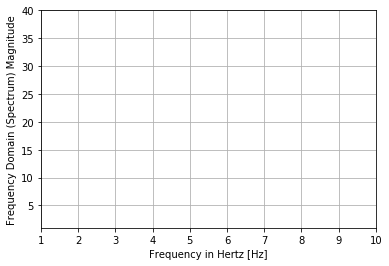

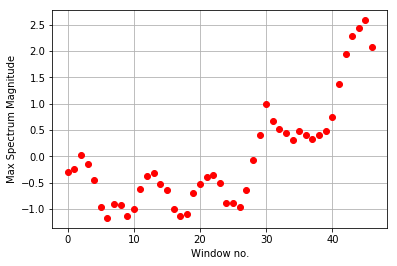

==== FFT with subjects # 1 ====


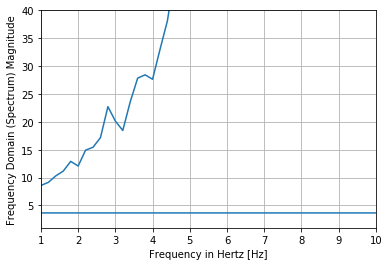

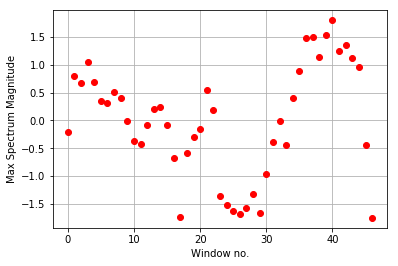

==== FFT with subjects # 2 ====


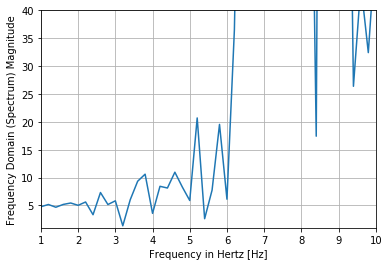

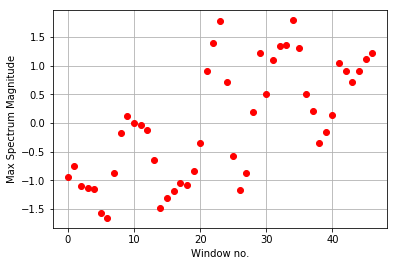

==== FFT with subjects # 3 ====


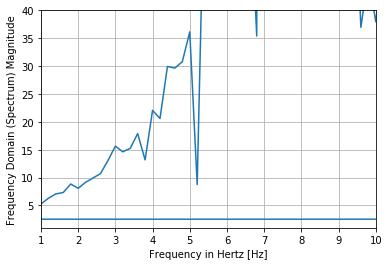

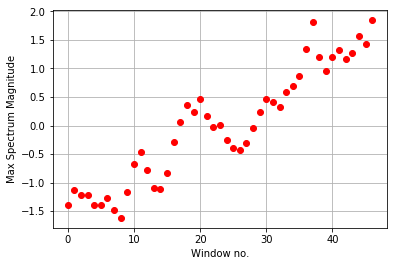

==== FFT with subjects # 4 ====


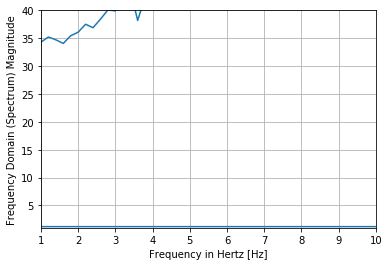

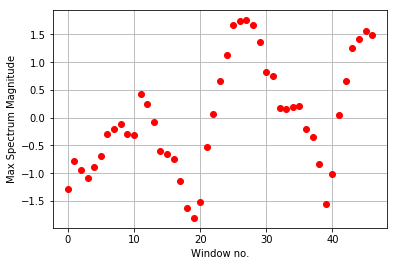

==== FFT with subjects # 5 ====


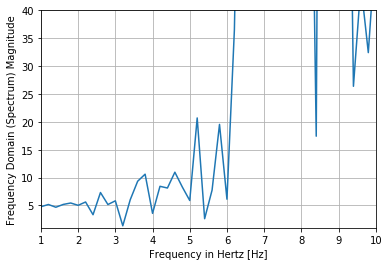

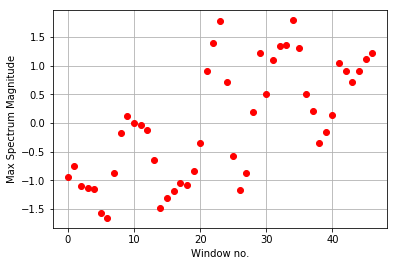

==== FFT with subjects # 6 ====


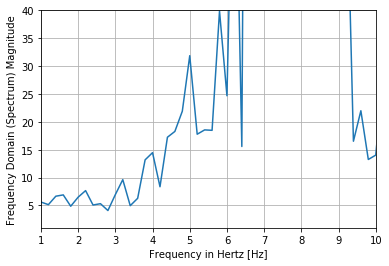

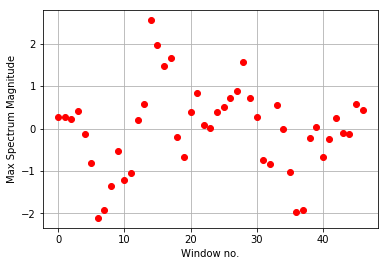

==== FFT with subjects # 7 ====


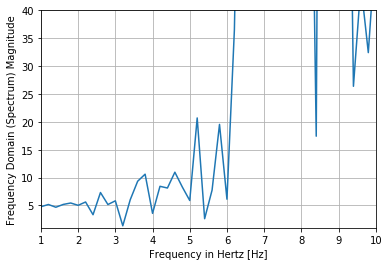

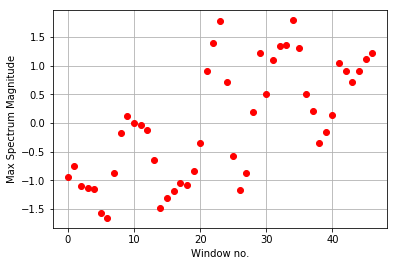

==== FFT with subjects # 8 ====


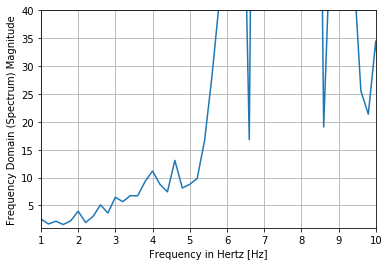

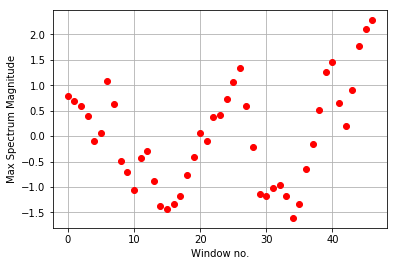

==== FFT with subjects # 9 ====


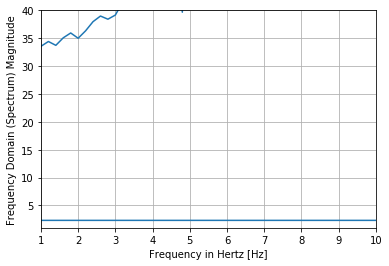

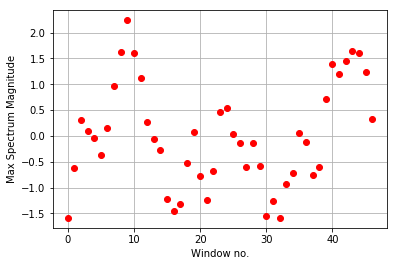

==== FFT with subjects # 10 ====


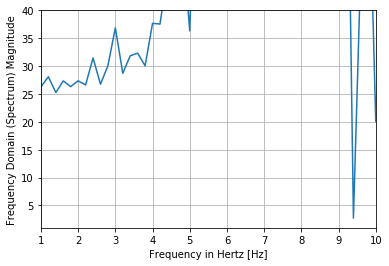

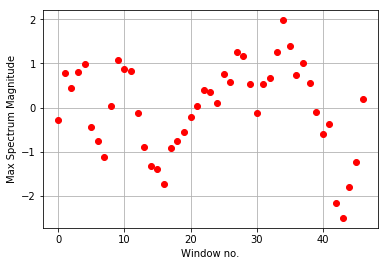

==== FFT with subjects # 11 ====


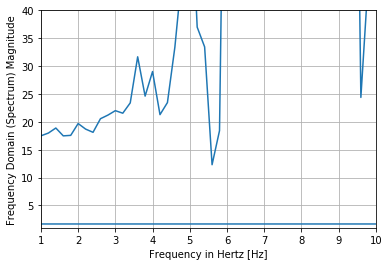

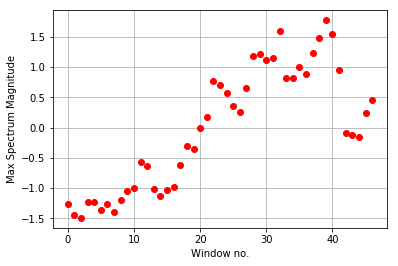

In [4]:
## perform Fast Fourier Transform (FFT)
#set params
window_size = 5 #seconds
number_of_slide_windows = used_secs-window_size+1
fft_out_max_list = np.zeros((number_of_subjects, number_of_slide_windows))
print "Each subjects contains", number_of_slide_windows, "windows."

#FFT
for i, d in enumerate(data_selected):
    print "==== FFT with subjects #", i, "===="
    for index in range(0, number_of_slide_windows):
        #one loop per window
#         print "From second #", index, "to", index+window_size-1,"( sampling no.", index*number_of_samplings_per_sec, "to", (index + window_size) * number_of_samplings_per_sec - 1, ")"
        
        #FFT
        fft_out = fft(d[index*number_of_samplings_per_sec : (index + window_size) * number_of_samplings_per_sec])
        
        #z-score normalization
        #fft_out = stats.zscore(fft_out)
        
        """
        #manual normalization (results are equal to above)
        mean = np.mean(fft_out)
        std = np.std(fft_out)
        fft_out = [ (f-mean)/std for f in fft_out ]
        """
        
        freqs = fftfreq(len(fft_out)) * number_of_samplings_per_sec
        
        #Get maximum magnitude value from window_size freq
        if window_size == 5:
            fix_freq = 7.6
        elif window_size == 6:
            fix_freq = 7.5
        elif window_size == 7:
            #still cannot find fix freq
            #peak is around 7.56-7.58
            #but after find from 7.5 to 7.8 (with scale + 0.00001), I still cannot find it
            pass
        elif window_size == 10:
            fix_freq = 7.6

        fft_out_max_list[i][index] = np.abs(fft_out)[np.where(freqs==fix_freq)]
        
        if index == number_of_slide_windows - 1:
            #plot FFT of some specific window
            fig, ax = plt.subplots()
            ax.plot(freqs, np.abs(fft_out))
            ax.set_xlabel('Frequency in Hertz [Hz]')
            ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
            ax.set_xlim(1, 10)
            ax.set_ylim(1, 40)
            plt.grid()
            plt.show() 
    #z-score normalization
    fft_out_max_list[i] = stats.zscore(fft_out_max_list[i])        
    plt.plot(fft_out_max_list[i], 'ro')
    plt.xlabel('Window no.')
    plt.ylabel('Max Spectrum Magnitude')
    plt.grid()
    plt.show()
                

In [5]:
def train_test_split(x, y, test_size = 1, fix_subject = None):
    
    r = []
    if fix_subject == None:
        while True:
            status = False
            for i in range(test_size):
                rand = 0
                while True:
                    rand = randint(0, number_of_subjects-1)
                    if rand not in r:
                        break
                    else:
                        print rand, r
                r.append(rand)

            for ri in rand_indices:
                if set(ri) == set(r):
                    r = []
                    status = True
                    break

            if not status:
                break
    else:
        r = [fix_subject]
            
            
    print "Random result: subject #", r, "is test set."
    rand_indices.append(r)
    
    y_test = np.array([y[i] for i in r][0])
    y_train = np.array([y[i] for i in range(number_of_subjects) if i not in r])
    x_tr = np.zeros(shape = ((number_of_subjects-test_size)*number_of_slide_windows, 1))
    y_tr = np.zeros(shape = ((number_of_subjects-test_size)*number_of_slide_windows, 1))
    x_te = np.zeros(shape = (number_of_slide_windows, 1))
    y_te = np.zeros(shape = (number_of_slide_windows, 1))
    
    x_tr =x[1:number_of_subjects-test_size+1].reshape(-1,1)
    y_tr =y_train.reshape(-1,1)
    x_te =x[1:test_size+1].reshape(-1,1)
    y_te =y_test.reshape(-1,1)
        
    return x_tr, \
            x_te, \
            y_tr, \
            y_te, \
            r

In [6]:
def write_result_to_csv(filename, results):
    print 'Start writing results from', len(results[0]), 'subjects'
    csvfile1 = open(filename + '_RMSE.csv', 'wb')
    csvfile2 = open(filename + '_testscore.csv', 'wb')
    
    wr1 = csv.writer(csvfile1, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    wr2 = csv.writer(csvfile2, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
    wr1.writerow(['subject_id', 'RMSE_full', 'RMSE_half', 'RMSE_quarter'])
    wr2.writerow(['subject_id', 'testscore_full', 'testscore_half', 'testscore_quarter'])
    
    for i in range(0, number_of_subjects):
        wr1.writerow([i, results[0][i]['RMSE'], results[1][i]['RMSE'], \
                      results[2][i]['RMSE']])
        wr2.writerow([i, results[0][i]['test_score'], results[1][i]['test_score'], \
                      results[2][i]['test_score']])
    
    csvfile1.close()
    csvfile2.close()
    
    print 'Finish writing :', filename

Parameter settings: 1st window start at intensity = 105 , end at intensity = 246 , cross validation = 12

#### Begin calculate with result proportion = 1 ####
Random result: subject # [0] is test set.


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


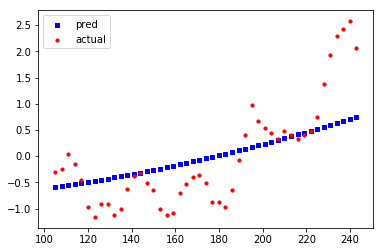

Random result: subject # [1] is test set.


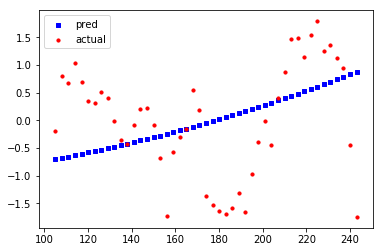

Random result: subject # [2] is test set.


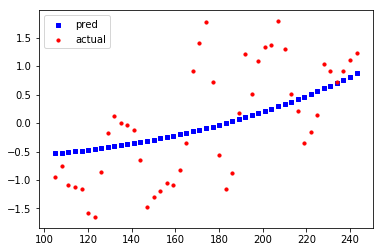

Random result: subject # [3] is test set.


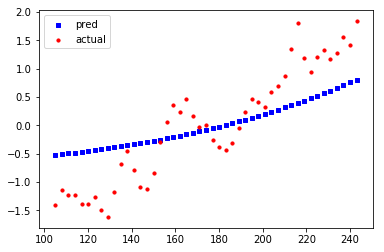

Random result: subject # [4] is test set.


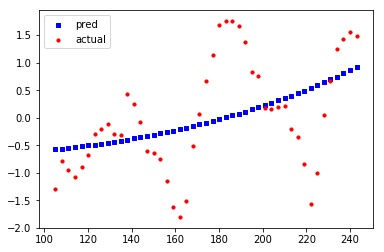

Random result: subject # [5] is test set.


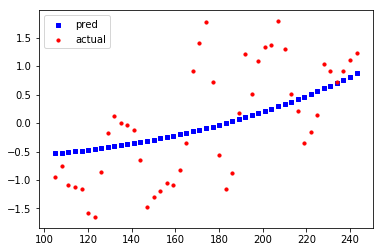

Random result: subject # [6] is test set.


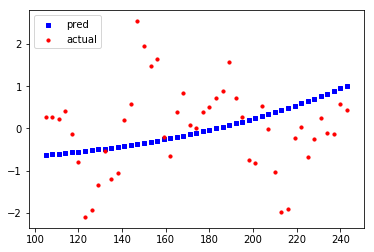

Random result: subject # [7] is test set.


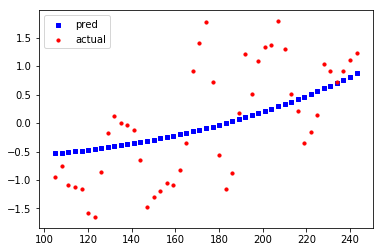

Random result: subject # [8] is test set.


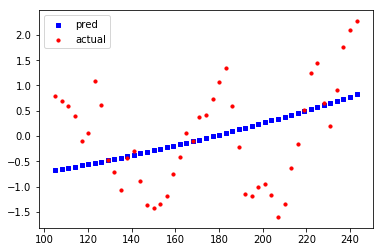

Random result: subject # [9] is test set.


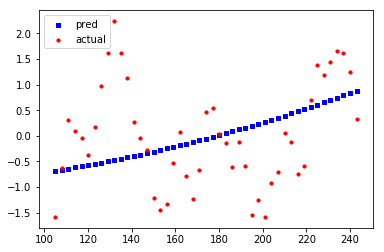

Random result: subject # [10] is test set.


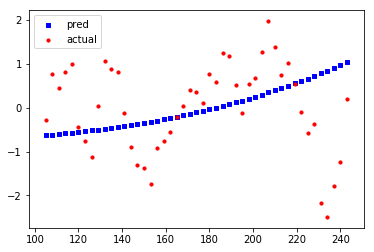

Random result: subject # [11] is test set.


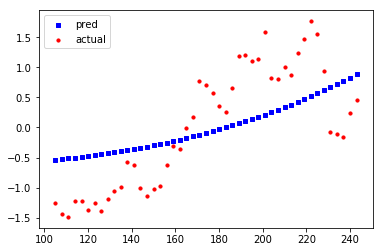

Store results of 12 subjects 47 points per subject done!

#### Begin calculate with result proportion = 0.5 ####
Random result: subject # [0] is test set.


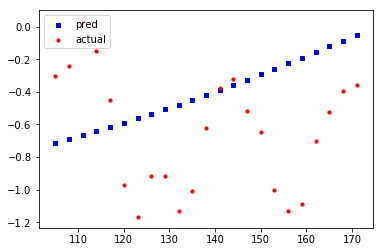

Random result: subject # [1] is test set.


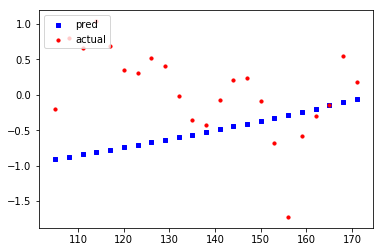

Random result: subject # [2] is test set.


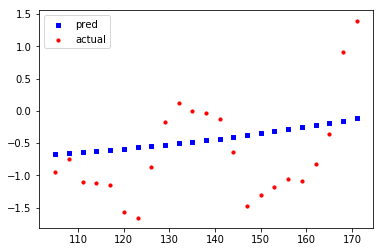

Random result: subject # [3] is test set.


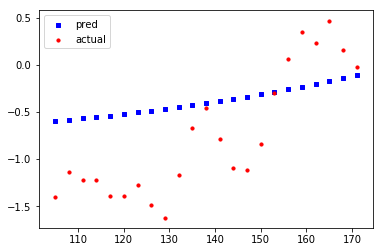

Random result: subject # [4] is test set.


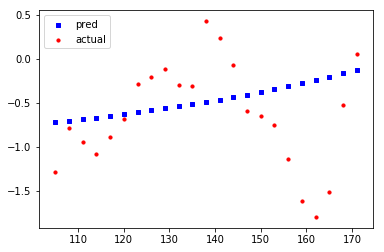

Random result: subject # [5] is test set.


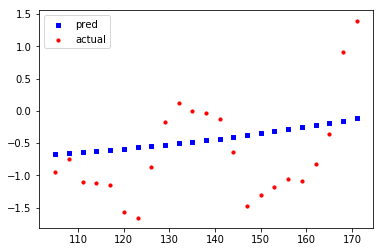

Random result: subject # [6] is test set.


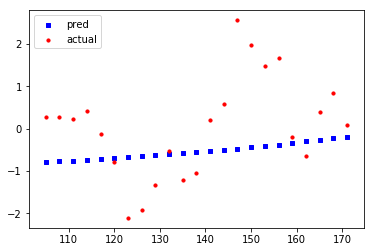

Random result: subject # [7] is test set.


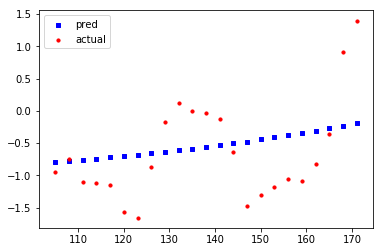

Random result: subject # [8] is test set.


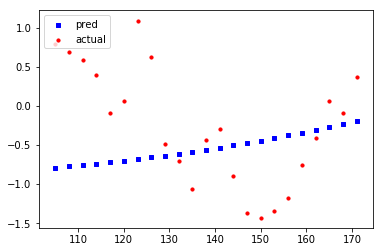

Random result: subject # [9] is test set.


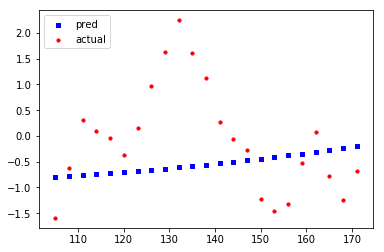

Random result: subject # [10] is test set.


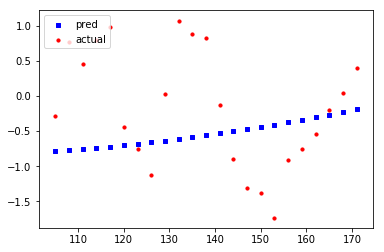

Random result: subject # [11] is test set.


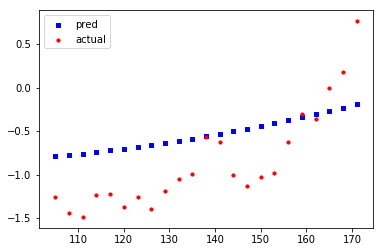

Store results of 12 subjects 23 points per subject done!

#### Begin calculate with result proportion = 0.25 ####
Random result: subject # [0] is test set.


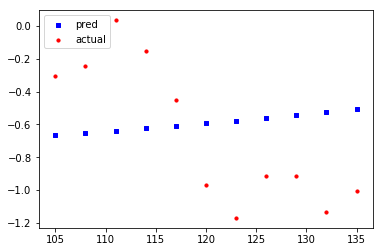

Random result: subject # [1] is test set.


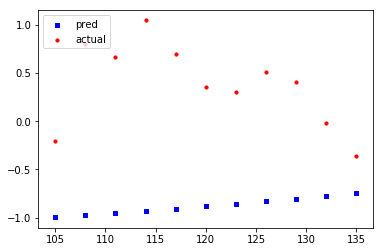

Random result: subject # [2] is test set.


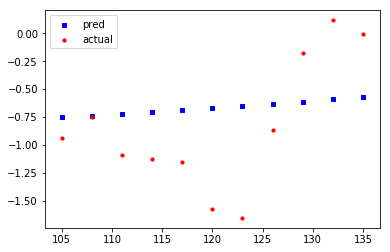

Random result: subject # [3] is test set.


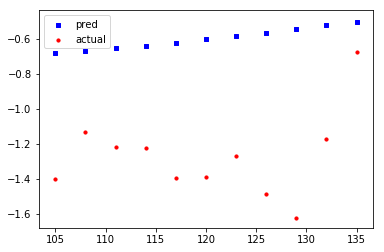

Random result: subject # [4] is test set.


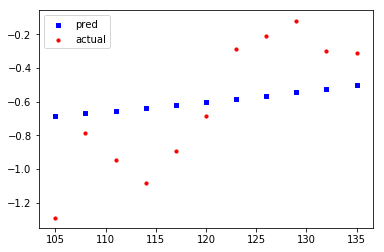

Random result: subject # [5] is test set.


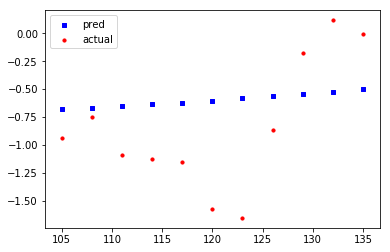

Random result: subject # [6] is test set.


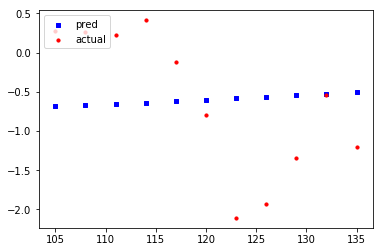

Random result: subject # [7] is test set.


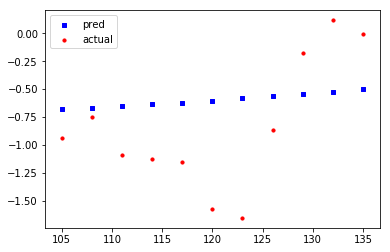

Random result: subject # [8] is test set.


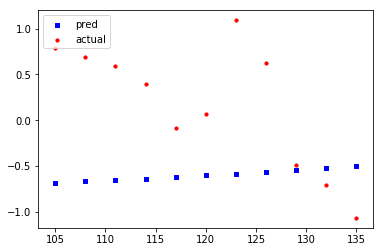

Random result: subject # [9] is test set.


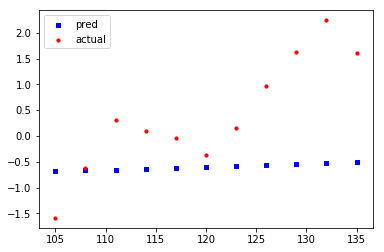

Random result: subject # [10] is test set.


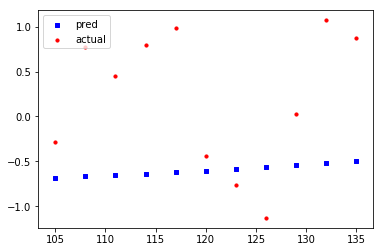

Random result: subject # [11] is test set.


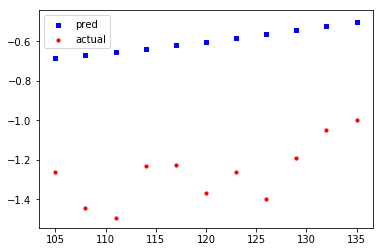

Store results of 12 subjects 11 points per subject done!

Start writing results from 12 subjects
Finish writing : ./tutorial_results


In [8]:
## Non-Linear Regression by Tutorial
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.001
lasso_nalpha=20
lasso_iter=1000

# set params
test_set_fraction = 1.0/12
test_size = 1
rand_indices = []
number_of_cv_rounds = number_of_subjects
intensity_step = 3
first_light_intensity_begin = 105
last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
        ", end at intensity =", last_light_intensity_begin, \
        ", cross validation =", number_of_cv_rounds
print

## prepare list to store results
tutorial_results = []
reduce_result_proportion = [1, 0.5, 0.25]
filename = './tutorial_results'

# Test/train split
light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
light_intensity = np.tile(light_intensity,(number_of_subjects,1))

for c, r in enumerate(reduce_result_proportion):
    print '#### Begin calculate with result proportion =', r, '####'
    tutorial_results.append([])
    
    for i in range(0, number_of_cv_rounds):
        # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, 
        # run it for increasing degree of polynomial (complexity of the model)

        model = make_pipeline(prep.PolynomialFeatures(degree=3, interaction_only=False), \
                              linear_model.LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,\
                                                   normalize=True,cv=number_of_cv_rounds))

        X_train, X_test, y_train, y_test, subject_id = train_test_split(x = light_intensity, y = fft_out_max_list, \
                                                                        test_size=test_size, fix_subject = i)
        
        X_train = X_train[:int(len(X_train)*r)]
        X_test = X_test[:int(len(X_test)*r)]
        y_train = y_train[:int(len(y_train)*r)]
        y_test = y_test[:int(len(y_test)*r)]
        
        model.fit(X_train,y_train)
        y_pred = np.array(model.predict(X_test))
        RMSE = np.sqrt(np.sum(np.square(y_pred-y_test)) / len(y_pred))
        test_score = model.score(X_test,y_test)

        ## store results
        tutorial_results[c].append(dict({
            'subject_id' : subject_id,
            'RMSE' : RMSE,
            'test_score' : test_score
        }))

        ## plot non-linear regression result
        x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
        x = x[:int(len(x)*r)]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)

        ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
        ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
        plt.legend(loc='upper left');
        plt.show()

    print 'Store results of', len(tutorial_results[c]), 'subjects', len(x), 'points per subject done!'
    print
    
write_result_to_csv(filename, tutorial_results)

Parameter settings: 1st window start at intensity = 105 , end at intensity = 246 , cross validation = 12

#### Begin calculate with result proportion = 1 ####
Random result: subject # [0] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 0 , RMSE: 0.7029275441472259 , test_score: 0.5058928676791496


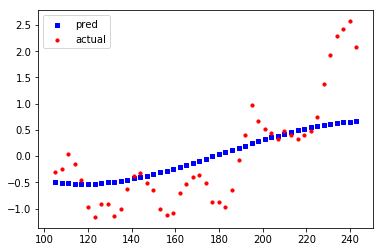

Random result: subject # [1] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 1 , RMSE: 1.0441720212778414 , test_score: -0.09029521001945295


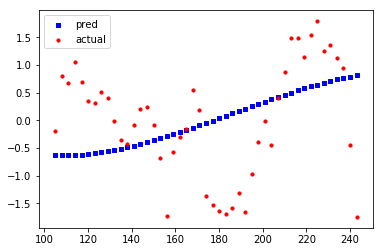

Random result: subject # [2] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 2 , RMSE: 0.7851879075611159 , test_score: 0.3834799498197965


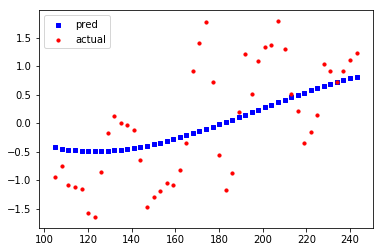

Random result: subject # [3] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 3 , RMSE: 0.6366456973508491 , test_score: 0.594682256044651


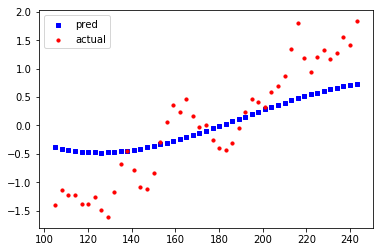

Random result: subject # [4] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 4 , RMSE: 0.9033546945296443 , test_score: 0.183950295871253


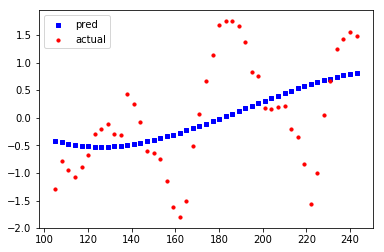

Random result: subject # [5] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 5 , RMSE: 0.7851879075611155 , test_score: 0.38347994981979716


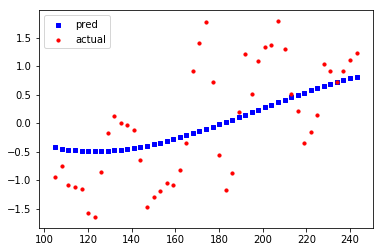

Random result: subject # [6] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 6 , RMSE: 1.1509779838472258 , test_score: -0.3247503193010248


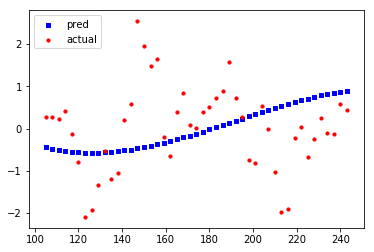

Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 7 , RMSE: 0.7851879075611149 , test_score: 0.38347994981979805


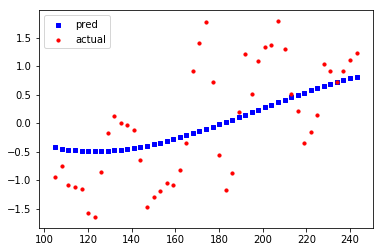

Random result: subject # [8] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 8 , RMSE: 0.9861101867847352 , test_score: 0.027586699519374758


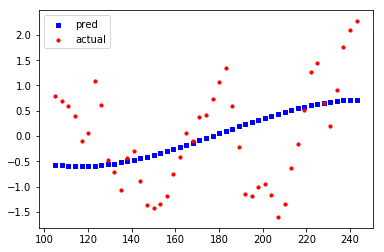

Random result: subject # [9] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 9 , RMSE: 1.0773229279075838 , test_score: -0.1606246909953688


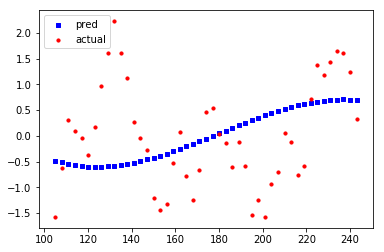

Random result: subject # [10] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 10 , RMSE: 1.1772429146304313 , test_score: -0.3859008800475529


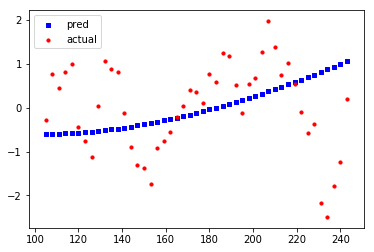

Random result: subject # [11] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 11 , RMSE: 0.7530949243580317 , test_score: 0.4328480349061708


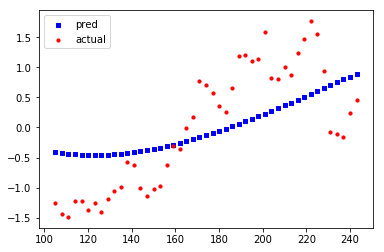

Store results of 12 subjects done!

#### Begin calculate with result proportion = 0.5 ####
Random result: subject # [0] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 0 , RMSE: 0.46079006185276766 , test_score: -0.7261781717638318


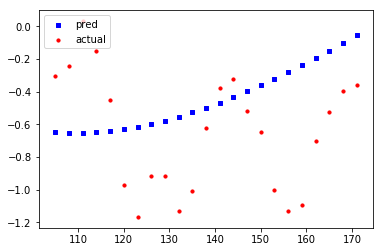

Random result: subject # [1] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 1 , RMSE: 0.9514938106507177 , test_score: -1.6216836559499845


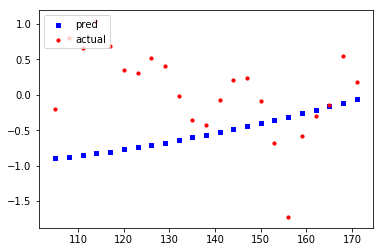

Random result: subject # [2] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 2 , RMSE: 0.730332962928877 , test_score: 0.06036628278569711


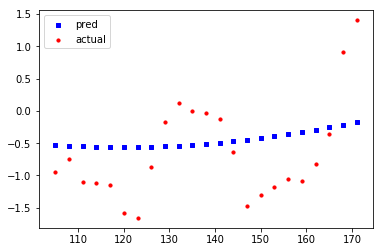

Random result: subject # [3] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 3 , RMSE: 0.6490489788125082 , test_score: 0.014232539046926895


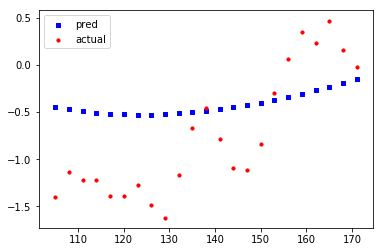

Random result: subject # [4] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 4 , RMSE: 0.6547644229809096 , test_score: -0.27856282210860006


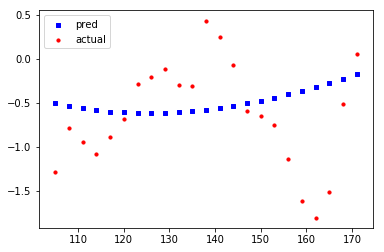

Random result: subject # [5] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 5 , RMSE: 0.7303329629288776 , test_score: 0.060366282785695335


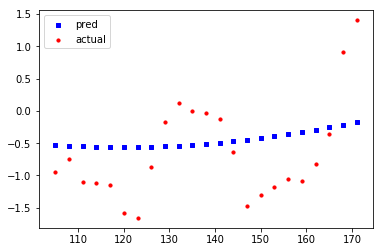

Random result: subject # [6] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 6 , RMSE: 1.262580551251012 , test_score: -0.189584372187801


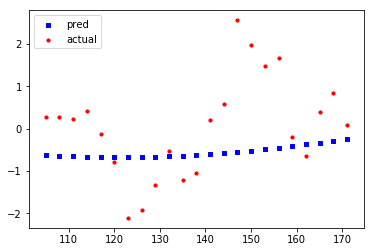

Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 7 , RMSE: 0.7044926068936861 , test_score: 0.1256815018711509


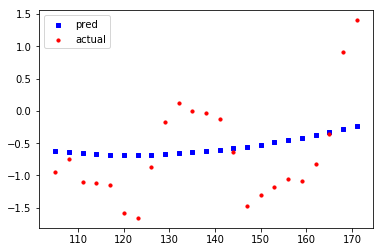

Random result: subject # [8] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 8 , RMSE: 0.8362710057079416 , test_score: -0.27270050051382344


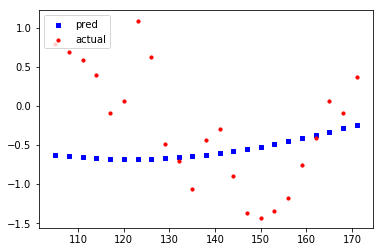

Random result: subject # [9] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 9 , RMSE: 1.1980864674837088 , test_score: -0.38020197587640303


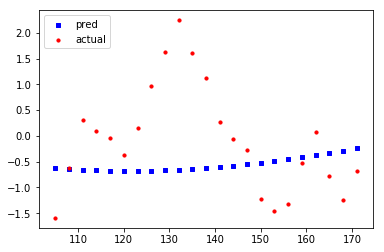

Random result: subject # [10] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 10 , RMSE: 0.9439952704547281 , test_score: -0.30464442545422377


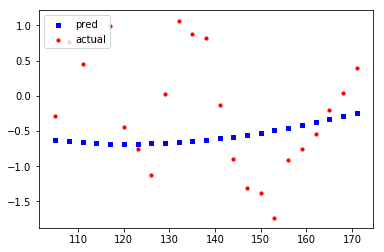

Random result: subject # [11] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 11 , RMSE: 0.5371964839884381 , test_score: 0.10423069720043132


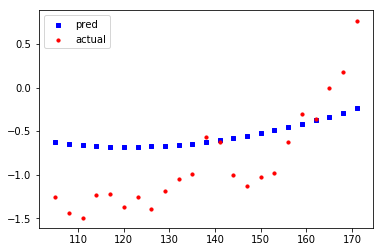

Store results of 12 subjects done!

#### Begin calculate with result proportion = 0.25 ####
Random result: subject # [0] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 0 , RMSE: 0.366596271931775 , test_score: 0.22676267607638334


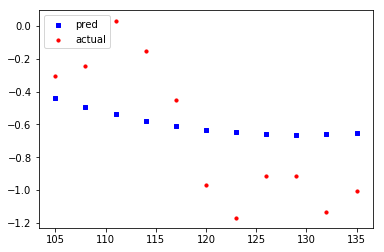

Random result: subject # [1] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 1 , RMSE: 1.3534279247445042 , test_score: -9.781700028561694


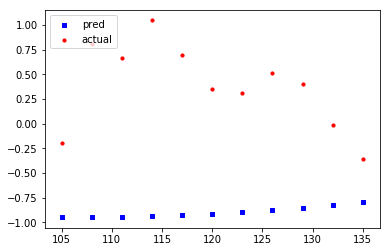

Random result: subject # [2] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 2 , RMSE: 0.7374503564780999 , test_score: -0.6996208837158456


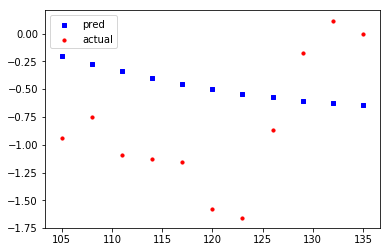

Random result: subject # [3] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 3 , RMSE: 0.9470457954199927 , test_score: -15.32090014989043


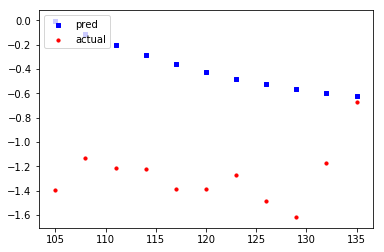

Random result: subject # [4] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 4 , RMSE: 0.6150146217418855 , test_score: -1.6026855738098935


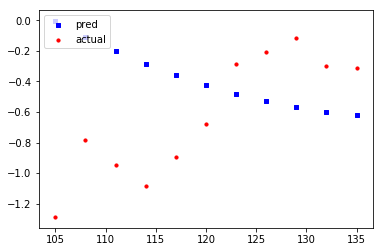

Random result: subject # [5] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 5 , RMSE: 0.8136777985645026 , test_score: -1.0691473139488923


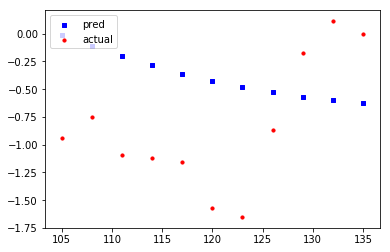

Random result: subject # [6] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 6 , RMSE: 0.7778924807099662 , test_score: 0.21199325833183247


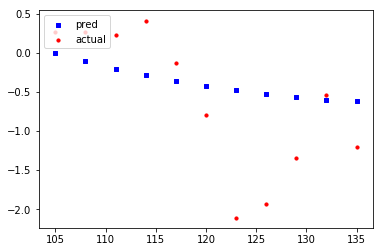

Random result: subject # [7] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 7 , RMSE: 0.8136777985645026 , test_score: -1.0691473139488923


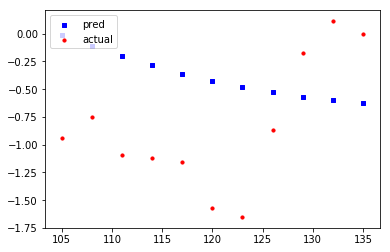

Random result: subject # [8] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 8 , RMSE: 0.7795661196556153 , test_score: -0.4137404113963197


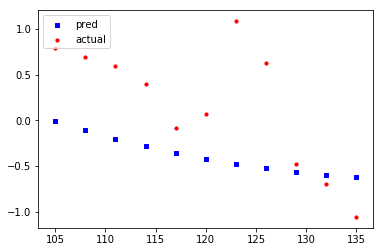

Random result: subject # [9] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 9 , RMSE: 1.4705984685279878 , test_score: -0.8843612802977582


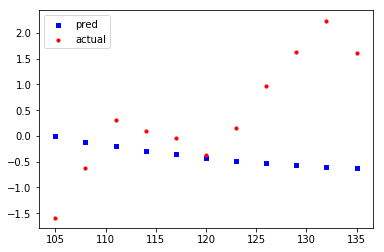

Random result: subject # [10] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 10 , RMSE: 0.9583527110360677 , test_score: -0.6961754362462778


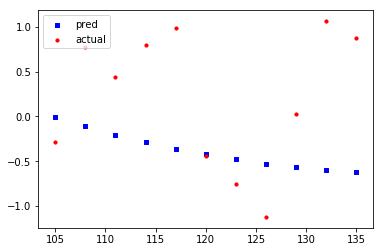

Random result: subject # [11] is test set.
X_train : 517 , X_test : 47 , y_train : 517 , y_test : 47

Round : 11 , RMSE: 0.9366098886108316 , test_score: -39.65646327298463


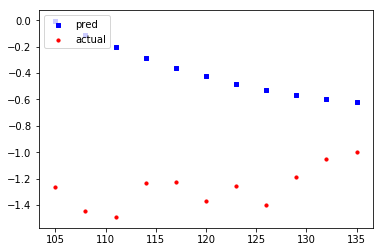

Store results of 12 subjects done!

Start writing results from 12 subjects
Finish writing : ./my_results


In [7]:
## Non-Linear Regression by me

# set params
test_set_fraction = 1.0/12
test_size = 1
rand_indices = []
results = []
number_of_cv_rounds = number_of_subjects
intensity_step = 3
first_light_intensity_begin = 105
last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
        ", end at intensity =", last_light_intensity_begin, \
        ", cross validation =", number_of_cv_rounds
print

# Test/train split
light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
light_intensity = np.tile(light_intensity,(number_of_subjects,1))

## prepare list to store results
results = []
reduce_result_proportion = [1, 0.5, 0.25]
filename = './my_results'

for c, r in enumerate(reduce_result_proportion):
    print '#### Begin calculate with result proportion =', r, '####'
    results.append([])
    
    for i in range(0, number_of_cv_rounds):
        X_train, X_test, y_train, y_test, subject_id = train_test_split(x = light_intensity, y = fft_out_max_list, \
                                                                test_size=test_size, fix_subject = i)
        print "X_train :", len(X_train), ", X_test :", len(X_test), ", y_train :", len(y_train), ", y_test :", len(y_test)
        print
        
        X_train = X_train[:int(len(X_train)*r)]
        X_test = X_test[:int(len(X_test)*r)]
        y_train = y_train[:int(len(y_train)*r)]
        y_test = y_test[:int(len(y_test)*r)]

        ## non-linear regression
        model = prep.PolynomialFeatures(degree=3)
        X_tr = model.fit_transform(X_train)
        X_te = model.fit_transform(X_test)

        clf = linear_model.LinearRegression()
        clf.fit(X_tr, y_train)
        y_pred = clf.predict(X_te)

        # calculate Root Mean Square Error
        RMSE = np.sqrt(np.sum(np.square(y_pred-y_test))/ len(y_pred))
        test_score = clf.score(X_te,y_test)
        print "Round :", i, ", RMSE:", RMSE, ", test_score:", test_score
        
        #store results
        results[c].append(dict({
            'subject_id' : subject_id,
            'RMSE' : RMSE,
            'test_score' : test_score
        }))

        ## plot non-linear regression result
        x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
        x = x[:int(len(x)*r)]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)

        ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
        ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
        plt.legend(loc='upper left');
        plt.show()
        
    print 'Store results of', len(results[c]), 'subjects done!'
    print
    
write_result_to_csv(filename, results)

In [ ]:
# ## try linear regression (not be used)
# model = linear_model.LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# #calculate Mean Square Error
# mse = np.sum(abs(y_pred-y_test)) / len(y_test)

# ## plot linear regression result (not be used)
# x = list(itertools.islice(itertools.count(), first_light_intensity_begin, last_light_intensity_begin, intensity_step))
# fig = plt.figure()
# ax1 = fig.add_subplot(111)

# ax1.scatter(x, y_pred, s=10, c='b', marker="s", label='pred')
# ax1.scatter(x, y_test, s=10, c='r', marker="o", label='actual')
# plt.legend(loc='upper left');
# plt.show()